In [2]:
# !pip install pykan
!pip install pykan

In [3]:
import torch
import matplotlib.pyplot as plt
from kan import KAN, create_dataset
from kan.MLP import MLP as kan_MLP
from kan.feynman import get_feynman_dataset

In [4]:
torch.cuda.is_available()

False

In [5]:
class MLP(kan_MLP):

    def __init__(self, width, act='silu', save_act=True, seed=0, device='cpu'):
        super(MLP, self).__init__(width, act, save_act, seed, device)
    
        if act == 'silu':
            self.act_fun = torch.nn.SiLU()
        elif act == 'relu':
            self.act_fun = torch.nn.ReLU()
        elif act == 'tanh':
            self.act_fun = torch.nn.Tanh()

## Experiment Functions

In [6]:
def run_kan_feynman(dataset: str,
                          shape: list[int],
                          samples: int, # samples for both train and test (separated) sets,
                          test_samples: int = None,
                          start_grid: int = 3,
                          k: int = 3,
                          device='cuda' if torch.cuda.is_available() else 'cpu',
                          seed:int=42,
                          grids=[3, 5, 10, 20, 50, 100, 200],
                          steps_per_grid=200,
                          plot_model=False,
                          prune=False,
                          prune_threshold=1e-2,
                          steps_after_prune=200,
                          lamb=0.00,
                          opt="LBFGS",
                          actual_func = None):
    
    assert device in ['cpu', 'cuda']
    try:
        torch.manual_seed(seed)
    except Exception as e:
        print('Warning: could not set torch.manual_seed')
    

    if test_samples is None:
        test_samples = samples
    
    
    if actual_func is not None:
        f = actual_func
        dataset = create_dataset(f, n_var=2, train_num=samples, test_num=test_samples, seed=seed)
    else:
        try:
            symbol, expr, f, ranges = get_feynman_dataset(dataset)
        except ValueError:
            raise ValueError("Invalid dataset name")
        dataset = create_dataset(f, n_var=2, ranges=ranges, train_num=samples, test_num=samples, seed=seed)
        if not shape[-1] == 1:
            print(f"Warning: Output dimension {shape[-1]} is not 1. Forcing condition.")
            shape[-1] = 1
        if not shape[0] == len(ranges):
            print(f"Warning: Input dimension {shape[0]} does not match number of variables in dataset {len(ranges)}. Forcing condition.")
            shape[0] = len(ranges)


    dataset['train_input'] = dataset['train_input'].to(device)
    dataset['train_label'] = dataset['train_label'].to(device)
    dataset['test_input'] = dataset['test_input'].to(device)
    dataset['test_label'] = dataset['test_label'].to(device)

    # assert shape[0] == len(ranges), "Input dimension does not match number of variables in dataset"
    # print(shape)

    # Create a copy of shape before passing to KAN to avoid mutation
    # KAN's __init__ converts [2,5,1] to [[2,0],[5,0],[1,0]] in-place
    model = KAN(width=shape.copy(), grid=start_grid, k=k, seed=seed).to(device)

    per_grid_results = {}

    for i, g in enumerate(grids):
        if i > 0: #skip first iteration
            model = model.refine(g)
        
        print(f"Training grid: {g}")
        results = model.fit(dataset, opt=opt, steps=steps_per_grid, lamb=lamb) #, verbose=verbose)
        per_grid_results[g] = results

    if prune:
        print("Pruning model...")
        model = model.prune(prune_threshold)
        # Disable grid updates after pruning to avoid numerical instability with smaller network
        results = model.fit(dataset, opt=opt, steps=steps_after_prune, lamb=0.0, update_grid=False) #, verbose=verbose)
        per_grid_results['prunning'] = results
        

    if plot_model:
        model.plot()
        plt.show()

    best_test_rmse = min(per_grid_results.values(), key=lambda x: x['test_loss'][-1])['test_loss'][-1]
    
    return model, per_grid_results, best_test_rmse

In [7]:
def sweep_kan_feynman(dataset:str, width: int=5, depths=[2,3,4,5,6], seeds: list[int] = [42, 171, 3], lambs: list[float] = [0.0], **kwargs):

    all_results = {}
    best_test_rmse = float('inf')
    
    # Get dataset info to determine input dimension
    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
        n_inputs = len(ranges)
    except Exception as e:
        raise ValueError(f"Could not load dataset {dataset}")

    for depth in depths:
        all_results[depth] = {}
        for lamb in lambs:
            all_results[depth][lamb] = {}
            for seed in seeds:
                all_results[depth][lamb][seed] = {}
                # Build shape with correct input dimension and output dimension of 1
                # depth includes input and output layers, so we need depth-2 hidden layers
                if depth == 1:
                    shape = [n_inputs, 1]
                else:
                    shape = [n_inputs] + [width for _ in range(depth - 1)] + [1]


                model, per_grid_results, test_rmse = run_kan_feynman(dataset=dataset, shape=shape, **kwargs)
                    
                all_results[depth][lamb][seed] = {
                    'model': model,
                    'per_grid_results': per_grid_results,
                    'test_rmse': test_rmse
                }

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse

    return all_results, best_test_rmse

In [8]:
def feynman_human_kan_experiment(dataset: str, shape: list[int], seeds: int| list[int] = [42, 171, 3], samples: int = 1000, **kwargs):
    """
    Run feynman dataset experiment with human-constructed KAN
    """
    all_results = []
    for seed in seeds:
        results = run_kan_feynman(dataset=dataset,
                                seed=seed,
                                samples=samples,
                                shape=shape,
                                **kwargs)
        all_results.append(results)
    
    best_test_rmse = min([res[2] for res in all_results])

    print('==='*20)
    print(f'Best Test RMSE for human-constructed KAN on dataset {dataset}: {best_test_rmse:.4e}')

    return best_test_rmse, all_results
    

def feynman_not_pruned_kan_experiment(dataset: str, seeds: int | list[int], samples=1000, **kwargs):

    results = sweep_kan_feynman(dataset=dataset,
                                seeds=seeds,
                                samples=samples,
                                **kwargs)

    # print('==='*20)
    # print(f'Best Test RMSE for not pruned KAN on dataset {dataset}: {results[1]:.4e}')
    best_test_rmse = results[1]

    return best_test_rmse, results


def feynman_pruned_kan_experiment(dataset: str, seeds: int|list[int] = [42, 171, 3], samples: int = 1000, steps_after_prune: int = 100,  lambs=[1e-2, 1e-3], **kwargs):
    """
    Run feynman dataset experiment with pruned KAN
    """
    results, best_test_rmse = sweep_kan_feynman(dataset=dataset,
                                seeds=seeds,
                                samples=samples,
                                prune=True,
                                prune_threshold=0.01,
                                steps_after_prune=steps_after_prune,
                                lambs=lambs,
                                **kwargs)
    

    # get smallest shape with loss < 1e-2
    # get shape of best loss

    smallest_shape = None
    smallest_params = float('inf')
    shape_best_loss = None
    smallest_loss = float('inf')

    for depth, v in results.items():
        for lamb, vv in v.items():
            for seed, res in vv.items():
                test_rmse = res['test_rmse']
                model = res['model']
                shape = [p[0] if isinstance(p, list) else p for p in model.width]
                num_params = sum(p.numel() for p in model.parameters())


                if test_rmse < 1e-2:
                    if smallest_shape is None or sum(shape) < sum(smallest_shape):
                        if num_params > smallest_params and smallest_shape is not None:
                            print(f"Warning: Found smaller shape {shape} with more parameters {num_params} > {smallest_params}. Still taking smallest shape though.")
                        smallest_shape = shape
                        smallest_params = num_params

                if test_rmse < smallest_loss:
                    smallest_loss = test_rmse
                    shape_best_loss = shape


    
    # If no model achieved RMSE < 1e-2, print warning
    if smallest_shape is None:

        print(f"⚠️ WARNING: No model achieved RMSE < 1e-2 for dataset {dataset}")


    return smallest_shape, shape_best_loss, best_test_rmse, results

In [9]:
def feynman_mlp_experiment(dataset: str, seeds: int|list[int] = [42, 171, 3], samples: int = 1000, device='cuda' if torch.cuda.is_available() else 'cpu',
                           activations=['silu', 'relu', 'tanh'], depths = [2,3,4,5,6], steps=1400, lr=1, **kwargs):
    """
    Run feynman dataset experiment with MLP
    """

    assert device in ['cpu', 'cuda']

    all_results = {}
    best_test_rmse = float('inf')

    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
    except ValueError:
        raise ValueError("Invalid dataset name")
    
    for seed in seeds:
        try:
            torch.manual_seed(seed)
        except Exception as e:
            print(f"Warning: could not set seed due to error: {e}")

        dataset = create_dataset(f, n_var=len(ranges), ranges=ranges, train_num=samples, test_num=samples, seed=seed)
        dataset['train_input'] = dataset['train_input'].to(device)
        dataset['train_label'] = dataset['train_label'].to(device)
        dataset['test_input'] = dataset['test_input'].to(device)
        dataset['test_label'] = dataset['test_label'].to(device)

        all_results[seed] = {}
        
        for depth in depths:
            shape = [len(ranges)] + [5 for _ in range(depth-1)] + [1]

            all_results[seed][depth] = {}

            for act in activations:
                model = MLP(width=shape, act=act, seed=seed, device=device)

                results = model.fit(dataset=dataset, steps=steps, opt="LBFGS", lr=lr)
                all_results[seed][depth][act] = results

                test_rmse = min(results['test_loss'])

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                
    return all_results, best_test_rmse

In [10]:
def full_feynman_experiment(dataset: str, shape_human: list[int], seeds: list[int] = [42, 171, 3], samples: int = 1000, **kwargs):
    """
    Run full feynman dataset experiment with human-constructed KAN, not pruned KAN, pruned KAN, and MLP
    """

    print('Running Human-constructed KAN Experiment...')
    h_best_test_rmse, h_results = feynman_human_kan_experiment(dataset=dataset, shape=shape_human, seeds=seeds, samples=samples, **kwargs)
    print(f'Best Test RMSE for human-constructed KAN on dataset {dataset}: {h_best_test_rmse:.4e}')

    print('--------------------------------') 
    print('Running Not Pruned KAN Experiment...')
    not_pruned_best_rmse, not_pruned_results = feynman_not_pruned_kan_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
    print(f'Best Test RMSE for not pruned KAN on dataset {dataset}: {not_pruned_best_rmse:.4e}')

    print('--------------------------------') 
    print('Running Pruned KAN Experiment...')
    pruned_smallest_shape, pruned_shape_best_loss, pruned_best_rmse, pruned_results = feynman_pruned_kan_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
    print(f'Pruned KAN Smallest Shape: {pruned_smallest_shape}, ')
    print(f'Pruned KAN lowest loss Shape: {pruned_shape_best_loss}, ')
    print(f'Pruned KAN lowest loss: {pruned_best_rmse:.4e}')

    print('--------------------------------') 
    print('Running MLP Experiment...')
    mlp_results, mlp_best_rmse = feynman_mlp_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
    print(f'MLP lowest loss: {mlp_best_rmse:.4e}')

    print('--------------------------------') 
    print('==='*40)
    print('==='*40)
    print(f'Final Results for dataset {dataset}:')
    print(f'Pruned KAN Smallest Shape: {pruned_smallest_shape}, ')
    print(f'Pruned KAN lowest loss Shape: {pruned_shape_best_loss}, ')
    print(f'Pruned KAN lowest loss: {pruned_best_rmse:.4e}')
    print(f'Human-constructed KAN loss: {h_best_test_rmse:.4e}')
    print(f'UnPruned KAN lowest loss: {not_pruned_best_rmse:.4e}')
    print(f'MLP lowest loss: {mlp_best_rmse:.4e}')
    print('==='*40)
    print('==='*40)

    return pruned_smallest_shape, pruned_shape_best_loss, pruned_best_rmse, pruned_results

In [11]:
def plot_train_test_loss(results, best_test_rmse) -> None:

    # Plot training and test losses
    # results is a list with one element per seed
    # Each element is (model, per_grid_results, best_test_rmse)
    model, per_grid_results, _ = results[0]  # Get results from the first (and only) seed

    # Concatenate losses from all grids
    train_losses = []
    test_losses = []
    grid_boundaries = [0]  # Track where each grid starts

    for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
        grid_results = per_grid_results[grid_size]
        train_losses.extend(grid_results['train_loss'])
        test_losses.extend(grid_results['test_loss'])
        grid_boundaries.append(len(train_losses))

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(test_losses, label='Test Loss', linewidth=2)

    # Add vertical lines to show grid refinements
    for i, boundary in enumerate(grid_boundaries[1:-1], start=1):
        plt.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss (RMSE)', fontsize=12)
    plt.title('Training and Test Losses for Dataset I.6.20 (samples=1000, seed=171)', fontsize=14)
    plt.legend(fontsize=11)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Train Loss: {train_losses[-1]:.4e}")
    print(f"Final Test Loss: {test_losses[-1]:.4e}")
    print(f"Best Test RMSE: {best_test_rmse:.4e}")

## Experiments

In [12]:
best_test_rmse, results = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1, 1], seeds=[171], samples=500)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 1.40e-03 | test_loss: 1.94e-03 | reg: 8.35e+00 | : 100%|█| 200/200 [00:42<00:00,  4.68


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 6.77e-04 | test_loss: 1.14e-03 | reg: 8.47e+00 | : 100%|█| 200/200 [00:27<00:00,  7.39


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 4.61e-04 | test_loss: 1.03e-03 | reg: 8.52e+00 | : 100%|█| 200/200 [00:29<00:00,  6.90


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 3.01e-04 | test_loss: 1.19e-03 | reg: 8.56e+00 | : 100%|█| 200/200 [00:37<00:00,  5.37


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.43e-04 | test_loss: 4.69e-03 | reg: 8.55e+00 | : 100%|█| 200/200 [01:01<00:00,  3.27
| train_loss: 1.43e-04 | test_loss: 4.69e-03 | reg: 8.55e+00 | : 100%|█| 200/200 [01:01<00:00,  3.27


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.99e-05 | test_loss: 7.69e-03 | reg: 8.55e+00 | : 100%|█| 200/200 [00:50<00:00,  3.99



saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.36e-01 | test_loss: 2.32e-01 | reg: 8.76e+00 | : 100%|█| 200/200 [01:54<00:00,  1.75

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 1.0326e-03


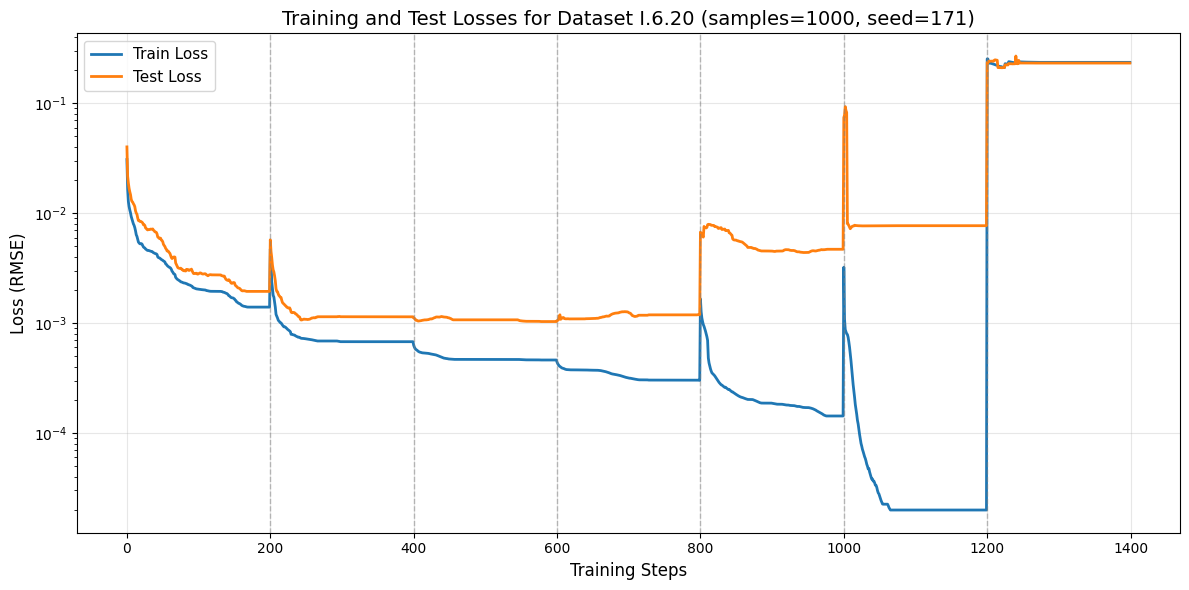


Final Train Loss: 2.3569e-01
Final Test Loss: 2.3222e-01
Best Test RMSE: 1.0326e-03


In [15]:
plot_train_test_loss(results, best_test_rmse)

In [16]:
best_test_rmse_1k, results_1k = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1, 1], seeds=[171], samples=1000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.13e-03 | test_loss: 1.09e-03 | reg: 9.18e+00 | : 100%|█| 200/200 [00:54<00:00,  3.66



saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 4.55e-02 | test_loss: 5.39e-02 | reg: 9.35e+00 | : 100%|█| 200/200 [01:08<00:00,  2.90



saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.38e-02 | test_loss: 4.96e-02 | reg: 1.06e+01 | : 100%|█| 200/200 [01:14<00:00,  2.68



saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 3.13e-02 | test_loss: 5.66e-02 | reg: 1.07e+01 | : 100%|█| 200/200 [00:58<00:00,  3.42



saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.62e-02 | test_loss: 6.38e-02 | reg: 1.07e+01 | : 100%|█| 200/200 [02:02<00:00,  1.63



saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.27e-01 | test_loss: 1.59e-01 | reg: 1.05e+01 | : 100%|█| 200/200 [02:22<00:00,  1.41



saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.08e-01 | test_loss: 1.40e-01 | reg: 9.81e+00 | : 100%|█| 200/200 [05:53<00:00,  1.77

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 1.0923e-03


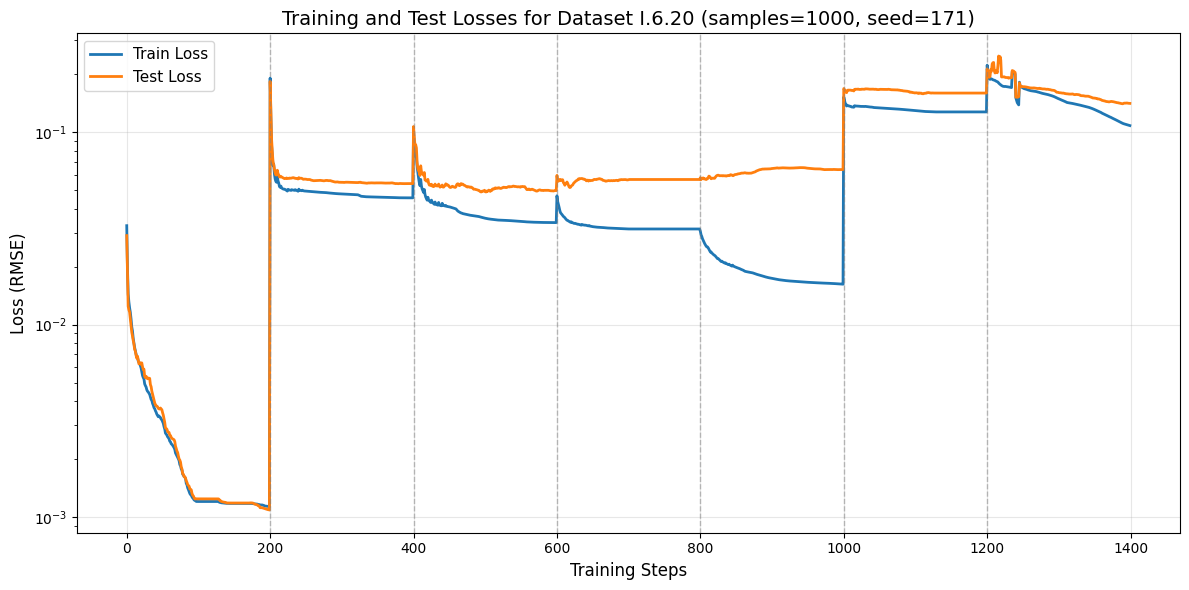


Final Train Loss: 1.0778e-01
Final Test Loss: 1.4048e-01
Best Test RMSE: 1.0923e-03


In [18]:
plot_train_test_loss(results_1k, best_test_rmse_1k)

In [12]:
best_test_rmse_2k5, results_2k5 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1, 1], seeds=[171], samples=2500)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.08e-03 | test_loss: 1.15e-03 | reg: 9.04e+00 | : 100%|█| 200/200 [02:48<00:00,  1.19


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.31e-02 | test_loss: 3.90e-02 | reg: 9.94e+00 | : 100%|█| 200/200 [03:16<00:00,  1.02


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.12e-02 | test_loss: 2.92e-02 | reg: 9.51e+00 | : 100%|█| 200/200 [04:50<00:00,  1.45


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.81e-02 | test_loss: 2.85e-02 | reg: 1.10e+01 | : 100%|█| 200/200 [05:29<00:00,  1.65


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.15e-02 | test_loss: 2.46e-02 | reg: 1.10e+01 | : 100%|█| 200/200 [09:39<00:00,  2.90


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.18e-02 | test_loss: 6.98e-02 | reg: 1.03e+01 | : 100%|█| 200/200 [14:56<00:00,  4.48


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.01e-02 | test_loss: 9.70e-02 | reg: 1.02e+01 | : 100%|█| 200/200 [28:26<00:00,  8.53

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 1.1491e-03


In [ ]:
plot_train_test_loss(results_2k5, best_test_rmse_2k5)

In [11]:
best_test_rmse_5k, results_5k = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1, 1], seeds=[171], samples=5000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 9.39e-03 | test_loss: 8.86e-03 | reg: 7.72e+00 | : 100%|█| 200/200 [01:51<00:00,  1.80



saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 8.59e-03 | test_loss: 8.12e-03 | reg: 7.48e+00 | : 100%|█| 200/200 [01:51<00:00,  1.79



saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.98e-02 | test_loss: 2.90e-02 | reg: 1.02e+01 | : 100%|█| 200/200 [02:08<00:00,  1.55
| train_loss: 1.98e-02 | test_loss: 2.90e-02 | reg: 1.02e+01 | : 100%|█| 200/200 [02:08<00:00,  1.55


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.48e-02 | test_loss: 2.36e-02 | reg: 1.04e+01 | : 100%|█| 200/200 [02:40<00:00,  1.25



saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.18e-02 | test_loss: 2.10e-02 | reg: 1.04e+01 | : 100%|█| 200/200 [04:30<00:00,  1.35



saving model version 0.9
saving model version 0.10
Training grid: 100
saving model version 0.10
Training grid: 100


| train_loss: 9.04e-03 | test_loss: 1.89e-02 | reg: 1.04e+01 | : 100%|█| 200/200 [08:04<00:00,  2.42



saving model version 0.11
saving model version 0.12
Training grid: 200
saving model version 0.12
Training grid: 200


| train_loss: 1.41e-02 | test_loss: 4.13e-02 | reg: 1.00e+01 | : 100%|█| 200/200 [16:50<00:00,  5.05

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 8.1202e-03


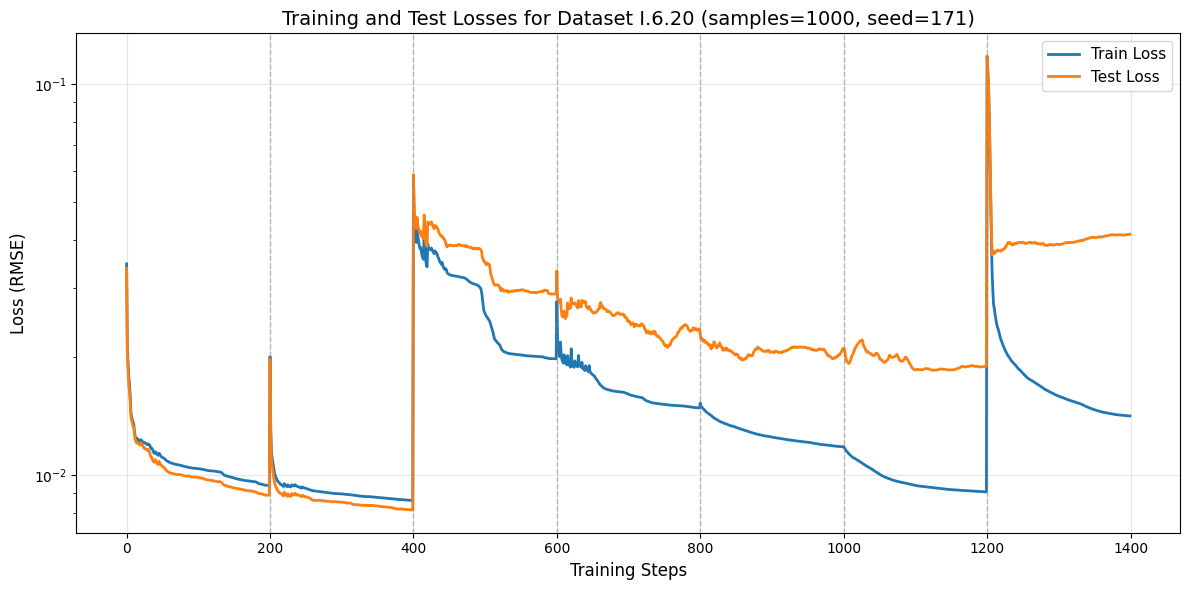


Final Train Loss: 1.4140e-02
Final Test Loss: 4.1287e-02
Best Test RMSE: 8.1202e-03


In [12]:
plot_train_test_loss(results_5k, best_test_rmse_5k)

In [13]:
best_test_rmse_15k, results_15k = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1, 1], seeds=[171], samples=15000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


description:   0%|                                                          | 0/200 [00:00<?, ?it/s]

| train_loss: 9.83e-04 | test_loss: 9.49e-04 | reg: 9.31e+00 | : 100%|█| 200/200 [04:28<00:00,  1.34



saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.75e-04 | test_loss: 2.85e-04 | reg: 9.98e+00 | : 100%|█| 200/200 [04:37<00:00,  1.39



saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 6.46e-05 | test_loss: 6.78e-05 | reg: 9.80e+00 | : 100%|█| 200/200 [05:30<00:00,  1.65



saving model version 0.5
saving model version 0.6
Training grid: 20
saving model version 0.6
Training grid: 20


| train_loss: 1.83e-05 | test_loss: 1.84e-05 | reg: 9.80e+00 | : 100%|█| 200/200 [04:11<00:00,  1.26



saving model version 0.7
saving model version 0.8
Training grid: 50
saving model version 0.8
Training grid: 50


| train_loss: 6.60e-06 | test_loss: 1.67e-05 | reg: 9.80e+00 | : 100%|█| 200/200 [07:44<00:00,  2.32



saving model version 0.9
saving model version 0.10
Training grid: 100
saving model version 0.10
Training grid: 100


| train_loss: 6.33e-06 | test_loss: 1.18e-04 | reg: 9.80e+00 | : 100%|█| 200/200 [09:58<00:00,  2.99



saving model version 0.11
saving model version 0.12
Training grid: 200
saving model version 0.12
Training grid: 200


| train_loss: 6.03e-06 | test_loss: 1.12e-03 | reg: 9.79e+00 | : 100%|█| 200/200 [22:13<00:00,  6.67

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 1.6659e-05


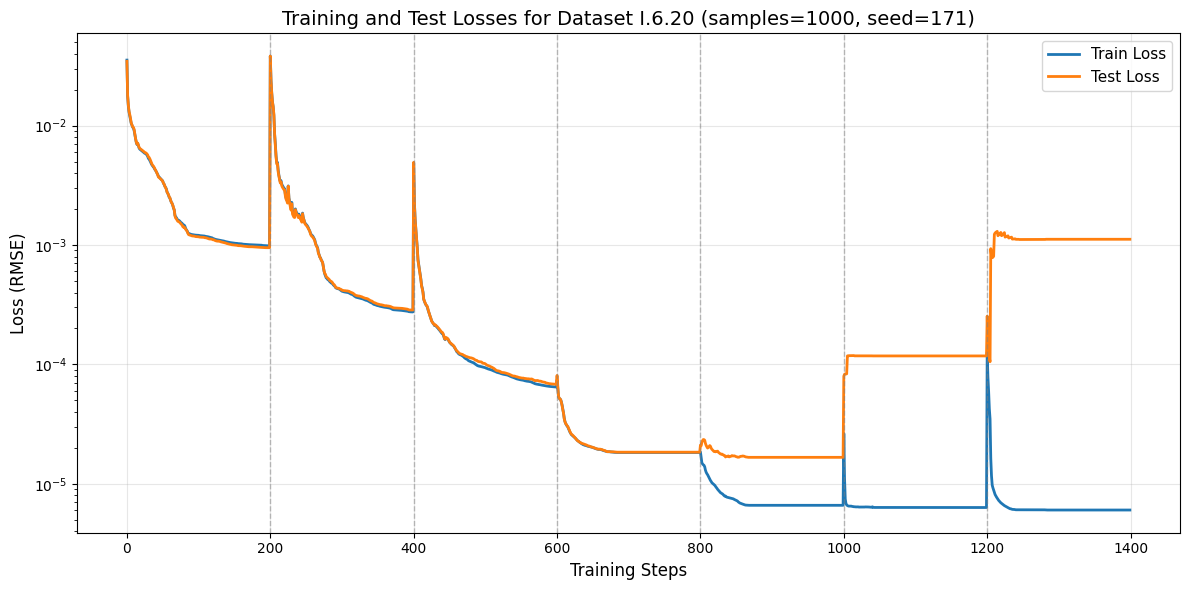


Final Train Loss: 6.0307e-06
Final Test Loss: 1.1167e-03
Best Test RMSE: 1.6659e-05


In [14]:
plot_train_test_loss(results_15k, best_test_rmse_15k)

In [ ]:
def plot_train_test_loss_small_multiples(results_dict: dict, dataset_name: str = 'I.6.20') -> None:
    """
    Plot training and test losses in small multiples (subplots) for comparison.
    
    Args:
        results_dict: Dictionary with keys as labels (e.g., '500 samples') and values as 
                     (best_test_rmse, results) tuples from feynman_human_kan_experiment
        dataset_name: Name of the dataset for the title
    """
    n_plots = len(results_dict)
    n_cols = min(3, n_plots)  # Max 3 columns
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # First pass: collect all losses to determine global y-axis scale
    all_train_losses = []
    all_test_losses = []
    
    for label, (best_test_rmse, results) in results_dict.items():
        model, per_grid_results, _ = results[0]
        
        train_losses = []
        test_losses = []
        
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            test_losses.extend(grid_results['test_loss'])
        
        all_train_losses.extend(train_losses)
        all_test_losses.extend(test_losses)
    
    # Determine global y-axis limits
    y_min = min(min(all_train_losses), min(all_test_losses))
    y_max = max(max(all_train_losses), max(all_test_losses))
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_plots > 1 else [axes]
    
    # Plot each result
    for idx, (label, (best_test_rmse, results)) in enumerate(results_dict.items()):
        ax = axes[idx]
        model, per_grid_results, _ = results[0]
        
        # Concatenate losses from all grids
        train_losses = []
        test_losses = []
        grid_boundaries = [0]
        
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            test_losses.extend(grid_results['test_loss'])
            grid_boundaries.append(len(train_losses))
        
        # Plot
        ax.plot(train_losses, label='Train Loss', linewidth=2)
        ax.plot(test_losses, label='Test Loss', linewidth=2)
        
        # Add vertical lines for grid refinements
        for i, boundary in enumerate(grid_boundaries[1:-1], start=1):
            ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        
        ax.set_xlabel('Training Steps', fontsize=11)
        ax.set_ylabel('Loss (RMSE)', fontsize=11)
        ax.set_title(f'{label}\nFinal Test RMSE: {best_test_rmse:.4e}', fontsize=12)
        ax.legend(fontsize=10)
        ax.set_yscale('log')
        ax.set_ylim(y_min, y_max)  # Set same y-axis scale for all plots
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    fig.suptitle(f'Training Comparison - Dataset {dataset_name}', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()


def plot_train_test_loss_combined(results_dict: dict, dataset_name: str = 'I.6.20', 
                                   plot_mode: str = 'both') -> None:
    """
    Plot all training and test losses on a single plot with different colors.
    
    Args:
        results_dict: Dictionary with keys as labels (e.g., '500 samples') and values as 
                     (best_test_rmse, results) tuples from feynman_human_kan_experiment
        dataset_name: Name of the dataset for the title
        plot_mode: 'train', 'test', or 'both' - determines which losses to plot
    """
    assert plot_mode in ['train', 'test', 'both'], "plot_mode must be 'train', 'test', or 'both'"
    
    # Define color palette
    colors = plt.cm.tab10(range(len(results_dict)))
    
    plt.figure(figsize=(14, 7))
    
    # Plot each result
    for idx, (label, (best_test_rmse, results)) in enumerate(results_dict.items()):
        model, per_grid_results, _ = results[0]
        color = colors[idx]
        
        # Concatenate losses from all grids
        train_losses = []
        test_losses = []
        grid_boundaries = [0]
        
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            test_losses.extend(grid_results['test_loss'])
            grid_boundaries.append(len(train_losses))
        
        # Plot based on mode
        if plot_mode in ['train', 'both']:
            plt.plot(train_losses, label=f'{label} - Train', linewidth=2.5, 
                    color=color, linestyle='-', alpha=0.8)
        
        if plot_mode in ['test', 'both']:
            plt.plot(test_losses, label=f'{label} - Test', linewidth=2.5, 
                    color=color, linestyle='--', alpha=0.8)
    
    # Add vertical lines for grid refinements (using the last result's boundaries)
    # Assuming all results have the same grid structure
    if results_dict:
        first_result = list(results_dict.values())[0]
        model, per_grid_results, _ = first_result[1][0]
        
        train_losses = []
        grid_boundaries = [0]
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            grid_boundaries.append(len(train_losses))
        
        for i, boundary in enumerate(grid_boundaries[1:-1], start=1):
            plt.axvline(x=boundary, color='gray', linestyle=':', alpha=0.3, linewidth=1.5)
    
    plt.xlabel('Training Steps', fontsize=13)
    plt.ylabel('Loss (RMSE)', fontsize=13)
    
    mode_text = {'train': 'Training', 'test': 'Test', 'both': 'Training and Test'}
    plt.title(f'{mode_text[plot_mode]} Losses Comparison - Dataset {dataset_name}', fontsize=15)
    
    plt.legend(fontsize=10, loc='best', ncol=1 if len(results_dict) <= 4 else 2)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print(f"Summary Statistics for {dataset_name}")
    print("="*60)
    for label, (best_test_rmse, results) in results_dict.items():
        model, per_grid_results, _ = results[0]
        
        train_losses = []
        test_losses = []
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            test_losses.extend(grid_results['test_loss'])
        
        print(f"\n{label}:")
        print(f"  Final Train Loss: {train_losses[-1]:.4e}")
        print(f"  Final Test Loss:  {test_losses[-1]:.4e}")
        print(f"  Best Test RMSE:   {best_test_rmse:.4e}")
    print("="*60)